In [1]:
#Digital Twin / Predictive Maintenance (Industry 4.0 Project)

In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

In [4]:
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Masking
except Exception:
    tf = None

print('Setup ready!')

Setup ready!


In [5]:
train_path = 'train_FD001.txt'
test_path =  'test_FD001.txt'
rul_path = 'RUL_FD001.txt'
col_names = (['unit_number', 'time_in_cycles']) + [f'op_serring_{i}'for i in range(1,4)] +[f'sensor_{i}' for i in range(1,22)]


train = pd.read_csv(train_path, sep = '\s+', header=None, names = col_names)
test = pd.read_csv(test_path, sep = '\s+', header=None, names = col_names)
rul = pd.read_csv(rul_path, sep = '\s+', header=None, names = ['RUL'])

print('train shape:', train.shape)
print('test shape:', test.shape)
print('rul shape:', rul.shape)

train.head()

train shape: (20631, 26)
test shape: (13096, 26)
rul shape: (100, 1)


,unit_number,time_in_cycles,op_serring_1,op_serring_2,op_serring_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [6]:
max_cycles = train.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycle']
train = train.merge(max_cycles, on = 'unit_number', how = 'left')
train['RUL'] = train['max_cycle'] - train['time_in_cycles']
train.drop(columns = ['max_cycle'], inplace = True)

rul_df = pd.DataFrame({'unit_number': test['unit_number'].unique(), 'RUL_true': rul["RUL"].values})
test = test.merge(rul_df, on= 'unit_number', how = 'left')

train[['unit_number', 'time_in_cycles', 'RUL']].head()

,unit_number,time_in_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [7]:
sensor_cols = [c for c in train.columns if c.startswith('sensor_')]
print('Run the plotting cells in the notebook to visualize cycles per unit and sensor correlations.')

Run the plotting cells in the notebook to visualize cycles per unit and sensor correlations.


In [8]:
RUL_THRESHOLD = 30
train['at_risk'] = (train['RUL'] <= RUL_THRESHOLD).astype(int)
test['at_risk_true'] = (test['RUL_true'] <= RUL_THRESHOLD).astype(int)


df_last = train.groupby('unit_number').apply(lambda x: x.sort_values('time_in_cycles').iloc[-1]).reset_index(drop=True)
features = [c for c in df_last.columns if c not in ['unit_number', 'time_in_cycles', 'RUL', 'at_risk']]
x_snapshot = df_last[features].copy()
y_snapshot = df_last['at_risk'].copy()


print('Snapshot dataset shape:', x_snapshot.shape)

Snapshot dataset shape: (100, 24)


In [9]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

imputer = SimpleImputer(strategy='median')
x_imp = pd.DataFrame(imputer.fit_transform(x_snapshot), columns = x_snapshot.columns)

scaler = StandardScaler()
x_scaled = pd.DataFrame(scaler.fit_transform(x_imp), columns = x_imp.columns)

x_tr, x_val, y_tr, y_val = train_test_split(x_scaled, y_snapshot, test_size= 0.2, random_state=42, stratify= y_snapshot)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, random_state = 42, n_jobs= -1)
rf.fit(x_tr, y_tr)
y_pred = rf.predict(x_val)


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print('Validation Accuracy:' , accuracy_score(y_val, y_pred))
print('\nClassification Report:\n', classification_report(y_val, y_pred))

Validation Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [10]:
def window_agg_features(df, window = 30 , features_list = None):
    records = []
    for unit, group in df.groupby('unit_number'):
        g = group.sort_values('time_in_cycles')
        last = g.iloc[-window:] if len(g) >= window else g
        row = {'unit_number': int(unit)}
        for col in features_list:
            row[f'{col}_mean'] = last[col].mean()
            row[f'{col}_std'] = last[col].std()
            row[f'{col}_min'] = last[col].min()
            row[f'{col}_max'] = last[col].max()
        row['at_risk'] = int(g.iloc[-1]['at_risk'])
        records .append(row)
    return pd.DataFrame(records)

features_base = [c for c in train.columns if c.startswith('sensor_') or c.startswith('op_setting_')]
df_window = window_agg_features(train, window=30, features_list = features_base)
x_w = df_window.drop(columns = ['unit_number', 'at_risk'])
y_w = df_window['at_risk']









from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier


x_train, x_val, y_train, y_val = train_test_split(x_w, y_w, test_size=0.2, random_state=42, stratify = y_w)

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_val)

print("Validation Accuracy:" , accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))



# x_w_imp = pd.DataFrame(imputer.fit_transform(x_w), columns=x_w.columns)
# x_w_scaled = pd.DataFrame(scaler.fit_transform(x_w_imp), columns = x_w_imp.columns)

# xw_tr, xw_val, yw_tr, yw_val = train_test_split(x_w_scaled, y_w, test_size= 0.2, random_state=42, stratify = y_w)
# rf_w = RandomForestClassifier(n_estimators=200, random_state = 42, n_jobs = -1)
# rf_w.fit(xw_tr, yw_tr)
# print('Windowed Validation Accuracy:', accuracy_score(yw_val, rf_w.predict(xw_val)))

Validation Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [11]:
# train['at_risk'].value_counts()

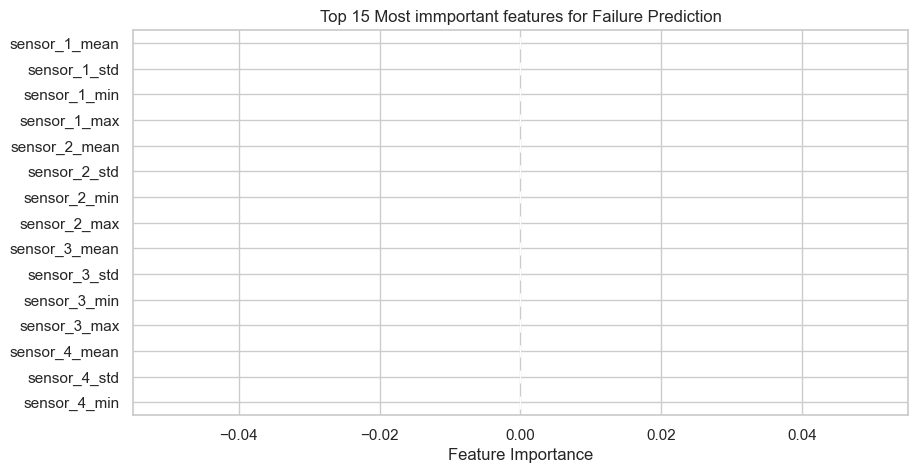

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
feat_imp = pd.Series(rf.feature_importances_, index = x_train.columns).sort_values(ascending=False).head(15)
plt.figure(figsize = (10,5))
feat_imp.plot(kind = 'barh')
plt.title('Top 15 Most immportant features for Failure Prediction')
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
seq_len = 30
sequence_list = []
rul_list = []

feat_cols = [c for c in train.columns if c.startswith('sensor_') or c.startswith('op_setting_')]
scaler_seq = StandardScaler()
train_feats = scaler_seq.fit_transform(train[feat_cols])
train_scaled = train.copy()
train_scaled[feat_cols] = train_feats

for units, g in train_scaled.groupby('unit_number'):
    g_sorted =  g.sort_values('time_in_cycles')
    feat_array = g_sorted[feat_cols].values
    for idx in range(len(g_sorted)):
        start = max(0, idx - seq_len+1)
        seq = feat_array[start:idx+1]
        sequence_list.append(seq)
        rul_list.append(g_sorted.iloc[idx]["RUL"])


x_seq = pad_sequences(sequence_list, dtype = 'float32', padding = 'pre', value = 0.0)
y_seq = np.array(rul_list)

print("Sequence dataset shape:", x_seq.shape, "target shape:", y_seq.shape)

Sequence dataset shape: (20631, 30, 21) target shape: (20631,)


In [14]:
n_features = x_seq.shape[2]
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense
model = Sequential([Masking(mask_value=0., input_shape=(x_seq.shape[1], n_features)),
                   LSTM(64, return_sequences=False),
                   Dense(32, activation='relu'),
                   Dense(1, activation='linear')
                   
                   ])

model.compile(optimizer='adam', loss= 'mse', metrics=['mae'])
model.summary()

                    

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 30, 21)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          22,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,129 (94.25 KB)

 Trainable params: 24,129 (94.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(x_seq, y_seq,
                   epochs=20,
                   batch_size=64,
                   validation_split=0.2,
                   verbose=1
                   )

Epoch 1/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 11617.7188 - mae: 86.4182 - val_loss: 3930.7617 - val_mae: 42.8296
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1858.7220 - mae: 29.6432 - val_loss: 2517.2297 - val_mae: 34.9620
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 1353.1083 - mae: 24.9385 - val_loss: 2132.3315 - val_mae: 32.4355
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1117.9413 - mae: 22.3582 - val_loss: 2318.7363 - val_mae: 31.9687
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1005.0823 - mae: 20.8766 - val_loss: 2345.3672 - val_mae: 31.0452
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 920.1987 - mae: 20.2298 - val_loss: 2067.0659 - val_mae: 30.0518
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 840.2152 - mae: 19.1684 - val_loss: 2139.1592 - val_mae: 30.3794
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 877.2336 - mae: 19.7706 - val_loss: 2184.7454 - val

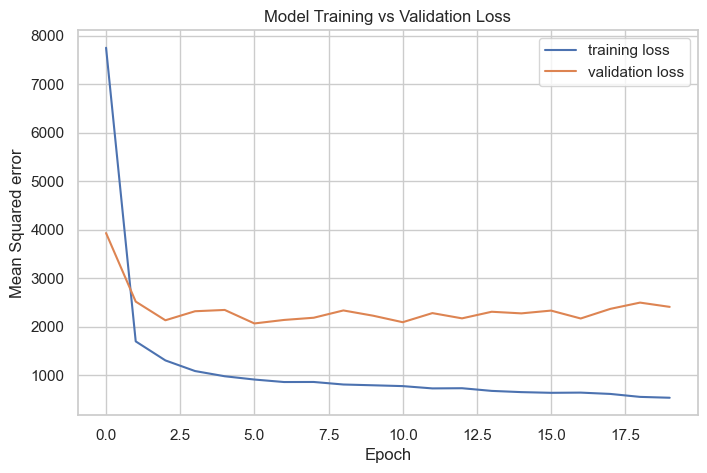

In [16]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Model Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared error')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[feat_cols])
scaled_test = scaler.transform(test[feat_cols])

In [18]:
from sklearn.feature_selection import VarianceThreshold


selector = VarianceThreshold(threshold=0.01)
selector.fit(scaled_train)
important_features = [feat_cols[i] for i in range (len(feat_cols)) if selector.get_support()[i]]
print("Selected sensors:", important_features)

Selected sensors: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']


In [20]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
model = Sequential([
    LSTM(128, input_shape=(x_seq.shape[1], x_seq.shape[2]), return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │          76,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 30, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,937 (546.63 KB)

 Trainable params: 139,553 (545.13 KB)

 Non-trainable params: 384 (1.50 KB)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [25]:
history = model.fit(x_seq, y_seq,
                   validation_split=0.2,
                   epochs=50,
                   batch_size=64,
                   verbose=1)

Epoch 1/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 14874.9932 - mae: 103.0496 - val_loss: 17898.2109 - val_mae: 108.6718
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 12599.7236 - mae: 91.6784 - val_loss: 15032.9326 - val_mae: 96.2419
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 9952.0166 - mae: 78.2836 - val_loss: 11765.9121 - val_mae: 80.9897
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 7347.0537 - mae: 63.8527 - val_loss: 8777.9609 - val_mae: 66.6002
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 5005.8340 - mae: 49.8352 - val_loss: 6341.8076 - val_mae: 53.5617
Epoch 6/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 3495.2610 - mae: 39.4998 - val_loss: 4654.6372 - val_mae: 44.3749
Epoch 7/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 2311.7346 - mae: 31.2209 - val_loss: 3753.9934 - val_mae: 40.1350
Epoch 8/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 1638.9945 - mae: 25.9132 - val_loss

645/645 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step


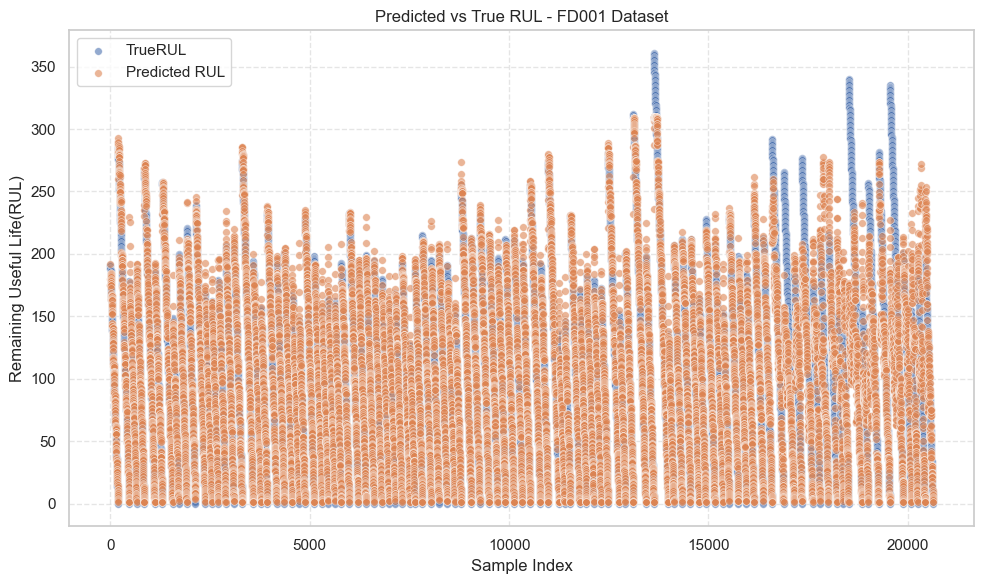

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

y_pred = model.predict(x_seq)
plt.figure(figsize = (10,6))
sns.scatterplot(x = range(len(y_seq)), y = y_seq, label = 'TrueRUL', alpha = 0.6, s = 30)
sns.scatterplot(x = range(len(y_seq)), y = y_pred.flatten(), label = 'Predicted RUL', alpha = 0.6, s = 30)
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life(RUL)')
plt.legend()
plt.title('Predicted vs True RUL - FD001 Dataset')
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.savefig("Predicted vs True RUL.png", dpi = 300, bbox_inches = 'tight')
plt.show()

In [34]:
plt.savefig("model_training_validation_loss.png", dpi = 300, bbox_inches = 'tight')

<Figure size 640x480 with 0 Axes>

In [36]:
# plt.figure(figsize=(8,5))
# plt.plot(history.history['loss'], label="training loss")
# plt.plot(history.history['val_loss'], label = 'validation loss')
# plt.title('Model Training vs Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Mean Squared error')
# plt.legend()
# plt.grid(True)
# plt.show()

In [31]:
model.save("FD001_RUL_LSTM_Model.h5")

In [32]:
import joblib
joblib.dump(scaler, "FD001_scaler.pkl")

['FD001_scaler.pkl']

In [ ]:
# I am a dedicated working professional with a strong foundation in AI and Data Science, aspiring to advance my expertise through a master’s in AI, Robotics, Mechatronics, or Computational Engineering. My skill set reflects my core strengths in data-driven problem solving, machine learning, and innovative technology applications.